In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.models import Sequential, Model, load_model
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.backend import clear_session
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50

In [3]:
path_dataset1 = 'C:\\Users\\MOHANJONNALA\\Desktop\\vbrainclassdeploy\\BrainData'
# path_dataset2 = '/kaggle/input/brain-tumor'

# Initialize an empty dataframe
df = pd.DataFrame(columns=["image_paths", "label"])

# Function to add data to the dataframe
def add_data_to_df(path, label_map):
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                df.loc[len(df)] = [image_path, label_map[label]]

# Mapping for dataset1
label_map_dataset1 = {
    'glioma_tumor': 'glioma',
    'meningioma_tumor': 'meningioma',
    'no_tumor': 'no_tumor',
    'pituitary_tumor': 'pituitary'
}

# Mapping for dataset2
# label_map_dataset2 = {
#     '1': 'glioma',
#     '2': 'meningioma',
#     '3': 'pituitary'
# }

# Add data from both datasets
for subfolder in ['Training', 'Testing']:
    add_data_to_df(os.path.join(path_dataset1, subfolder), label_map_dataset1)

add_data_to_df(path_dataset2, label_map_dataset2)

In [4]:
df.tail(10)

,image_paths,label
6318,/kaggle/input/brain-tumor/1/2879.png,glioma
6319,/kaggle/input/brain-tumor/1/2570.png,glioma
6320,/kaggle/input/brain-tumor/1/2927.png,glioma
6321,/kaggle/input/brain-tumor/1/2964.png,glioma
6322,/kaggle/input/brain-tumor/1/2652.png,glioma
6323,/kaggle/input/brain-tumor/1/3029.png,glioma
6324,/kaggle/input/brain-tumor/1/2383.png,glioma
6325,/kaggle/input/brain-tumor/1/2627.png,glioma
6326,/kaggle/input/brain-tumor/1/2392.png,glioma
6327,/kaggle/input/brain-tumor/1/2995.png,glioma


In [5]:
df.head(10)

,image_paths,label
0,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
1,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
2,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
3,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
4,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
5,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
6,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
7,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
8,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
9,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor


In [6]:
train, test = train_test_split(df, test_size= 0.2, random_state= 42)
training, validation = train_test_split(train, test_size= 0.25, random_state= 42, shuffle = True)

In [7]:
target_size = (224, 224)

# Data Augmentation for the training data
train_datagen = ImageDataGenerator( 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.2],
    fill_mode='nearest'
)

# Basic generator for validation and test data (no augmentation, just rescaling)
valid_test_datagen = ImageDataGenerator()

def create_dataset(df, is_training=False):
    if is_training:
        datagen = train_datagen
    else:
        datagen = valid_test_datagen
    return datagen.flow_from_dataframe(df, x_col='image_paths', y_col='label', class_mode='categorical', shuffle=is_training, target_size=target_size)

# Creating datasets
train_dataset = create_dataset(training, is_training=True)
valid_dataset = create_dataset(validation)
test_dataset = create_dataset(test)

Found 3796 validated image filenames belonging to 4 classes.
Found 1266 validated image filenames belonging to 4 classes.
Found 1266 validated image filenames belonging to 4 classes.


In [8]:
label_dict = train_dataset.class_indices
tumor_type = list(label_dict.keys())
images,labels=next(train_dataset)

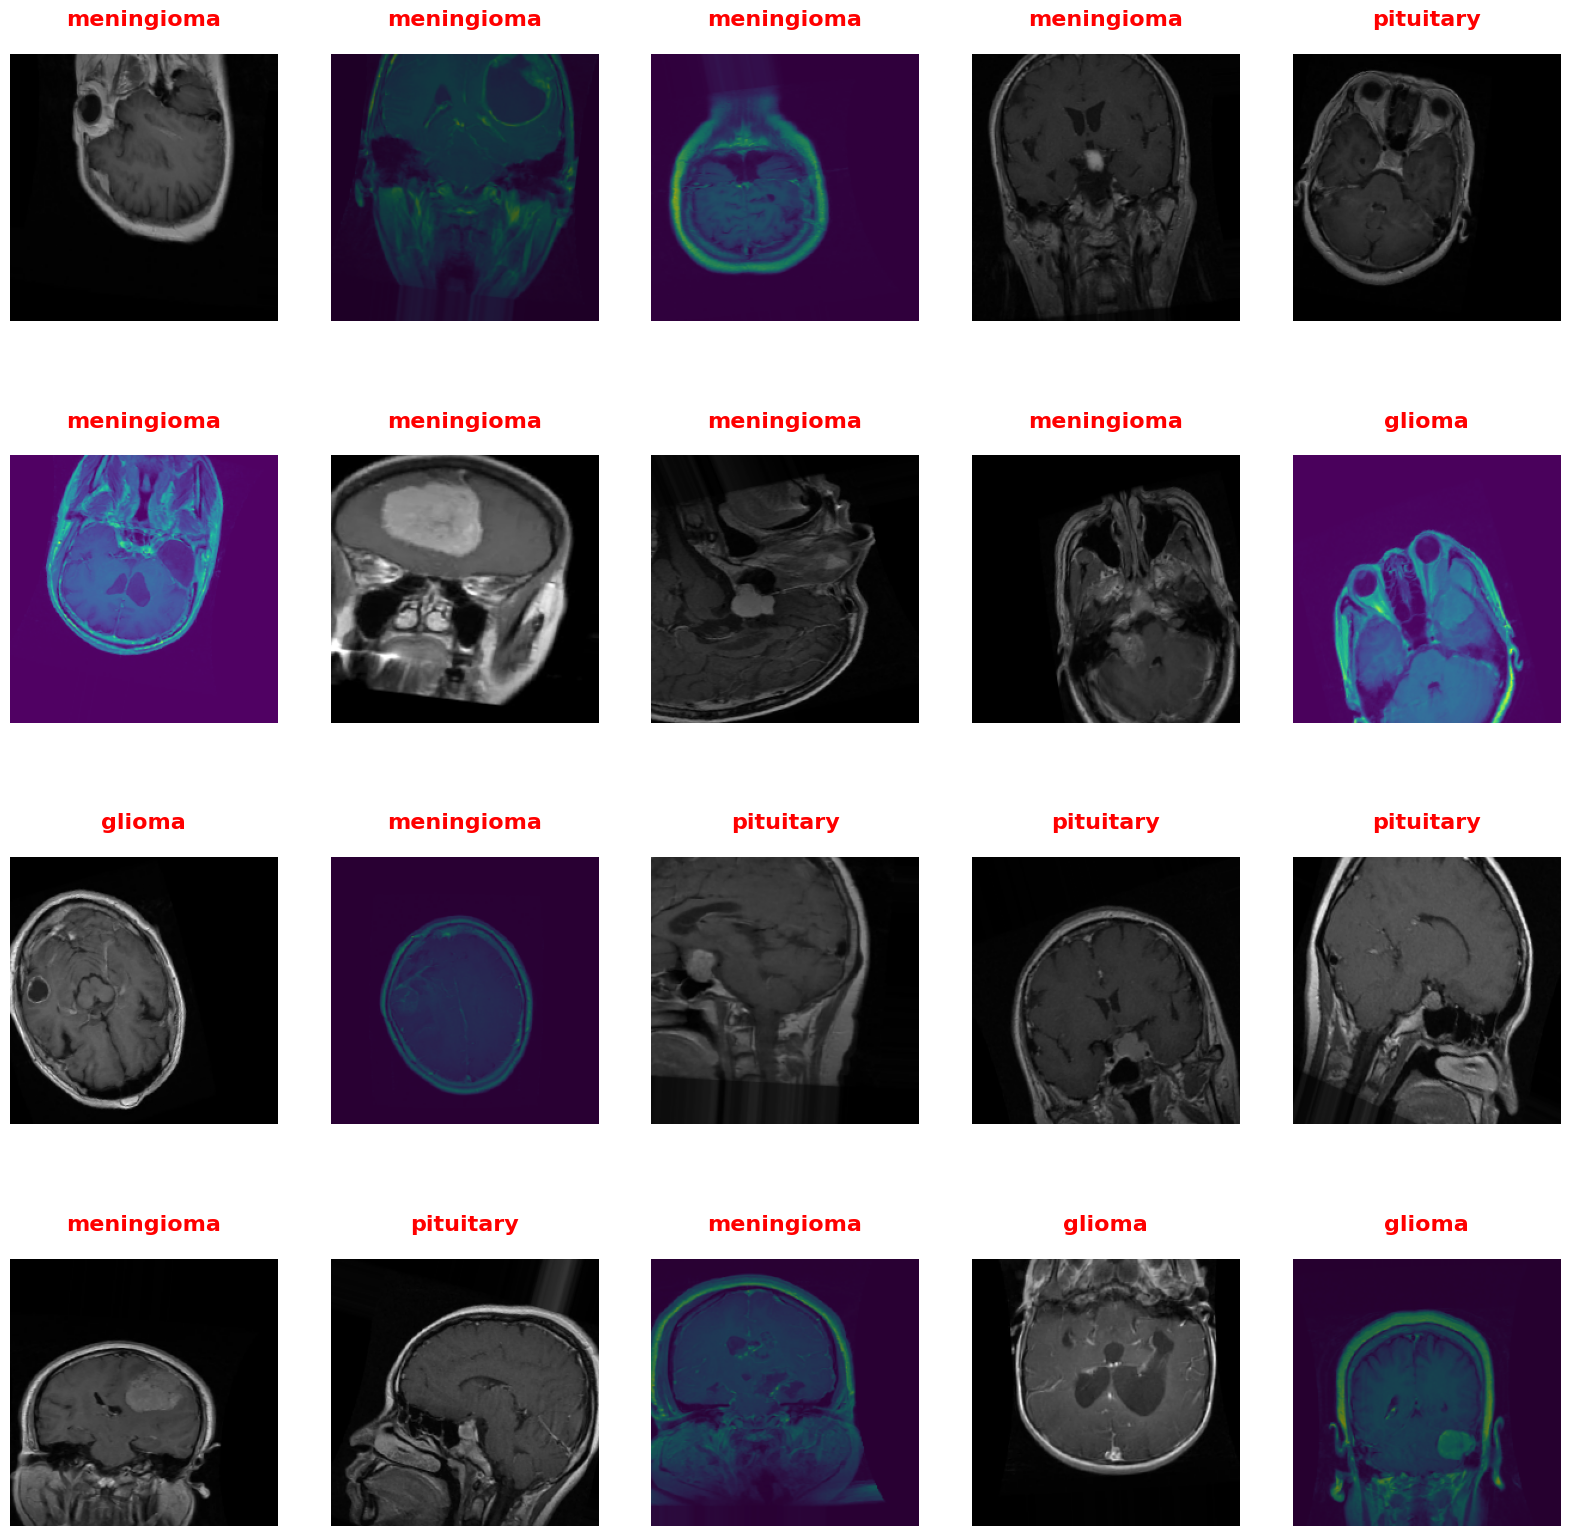

In [9]:
from matplotlib import rcParams

plt.figure(figsize= (20,20))
rcParams['axes.titlepad'] = 20

for i in range(20):
    plt.subplot(4,5,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    tumor_type_name = tumor_type[index]
    color = 'green' if tumor_type_name == 'no_tumor' else 'red'
    plt.title(tumor_type_name, fontsize=16, fontweight='bold', color=color)
    plt.axis('off')

plt.show()

In [10]:
# Fixing the seed for random number generators
import random
clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [12]:
loaded_model = load_model('/kaggle/input/tumor-detection-model/Tumor_pitu_glioma_menin_model.h5')

In [13]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 432)               663984    
                                                                 
 dropout (Dropout)           (None, 432)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1732      
                                                                 
Total params: 11455395 (43.70 MB)
Trainable params: 6687

In [14]:
unfreezed_layers = 5
learning_rate = 0.00379778

for layer in loaded_model.layers[-unfreezed_layers:]:
    layer.trainable = True

optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = loaded_model.fit(train_dataset,
                    epochs = 100,
                    validation_data = valid_dataset,
                    callbacks = [early_stop])

Epoch 1/100


2024-01-16 19:44:16.152585: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 [==============================] - 154s 1s/step - loss: 2.4464 - accuracy: 0.6818 - val_loss: 1.9911 - val_accuracy: 0.8041
Epoch 2/100
119/119 [==============================] - 84s 707ms/step - loss: 1.7457 - accuracy: 0.8372 - val_loss: 1.6331 - val_accuracy: 0.8720
Epoch 3/100
119/119 [==============================] - 85s 710ms/step - loss: 1.5454 - accuracy: 0.8833 - val_loss: 1.4418 - val_accuracy: 0.9139
Epoch 4/100
119/119 [==============================] - 84s 704ms/step - loss: 1.4101 - accuracy: 0.9139 - val_loss: 1.3963 - val_accuracy: 0.9131
Epoch 5/100
119/119 [==============================] - 84s 703ms/step - loss: 1.3221 - accuracy: 0.9320 - val_loss: 1.2965 - val_accuracy: 0.9336
Epoch 6/100
119/119 [==============================] - 84s 704ms/step - loss: 1.2467 - accuracy: 0.9328 - val_loss: 1.2165 - val_accuracy: 0.9487
Epoch 7/100
119/119 [==============================] - 84s 704ms/step - loss: 1.1993 - accuracy: 0.9334 - val_loss: 1.1754 - val_accuracy:

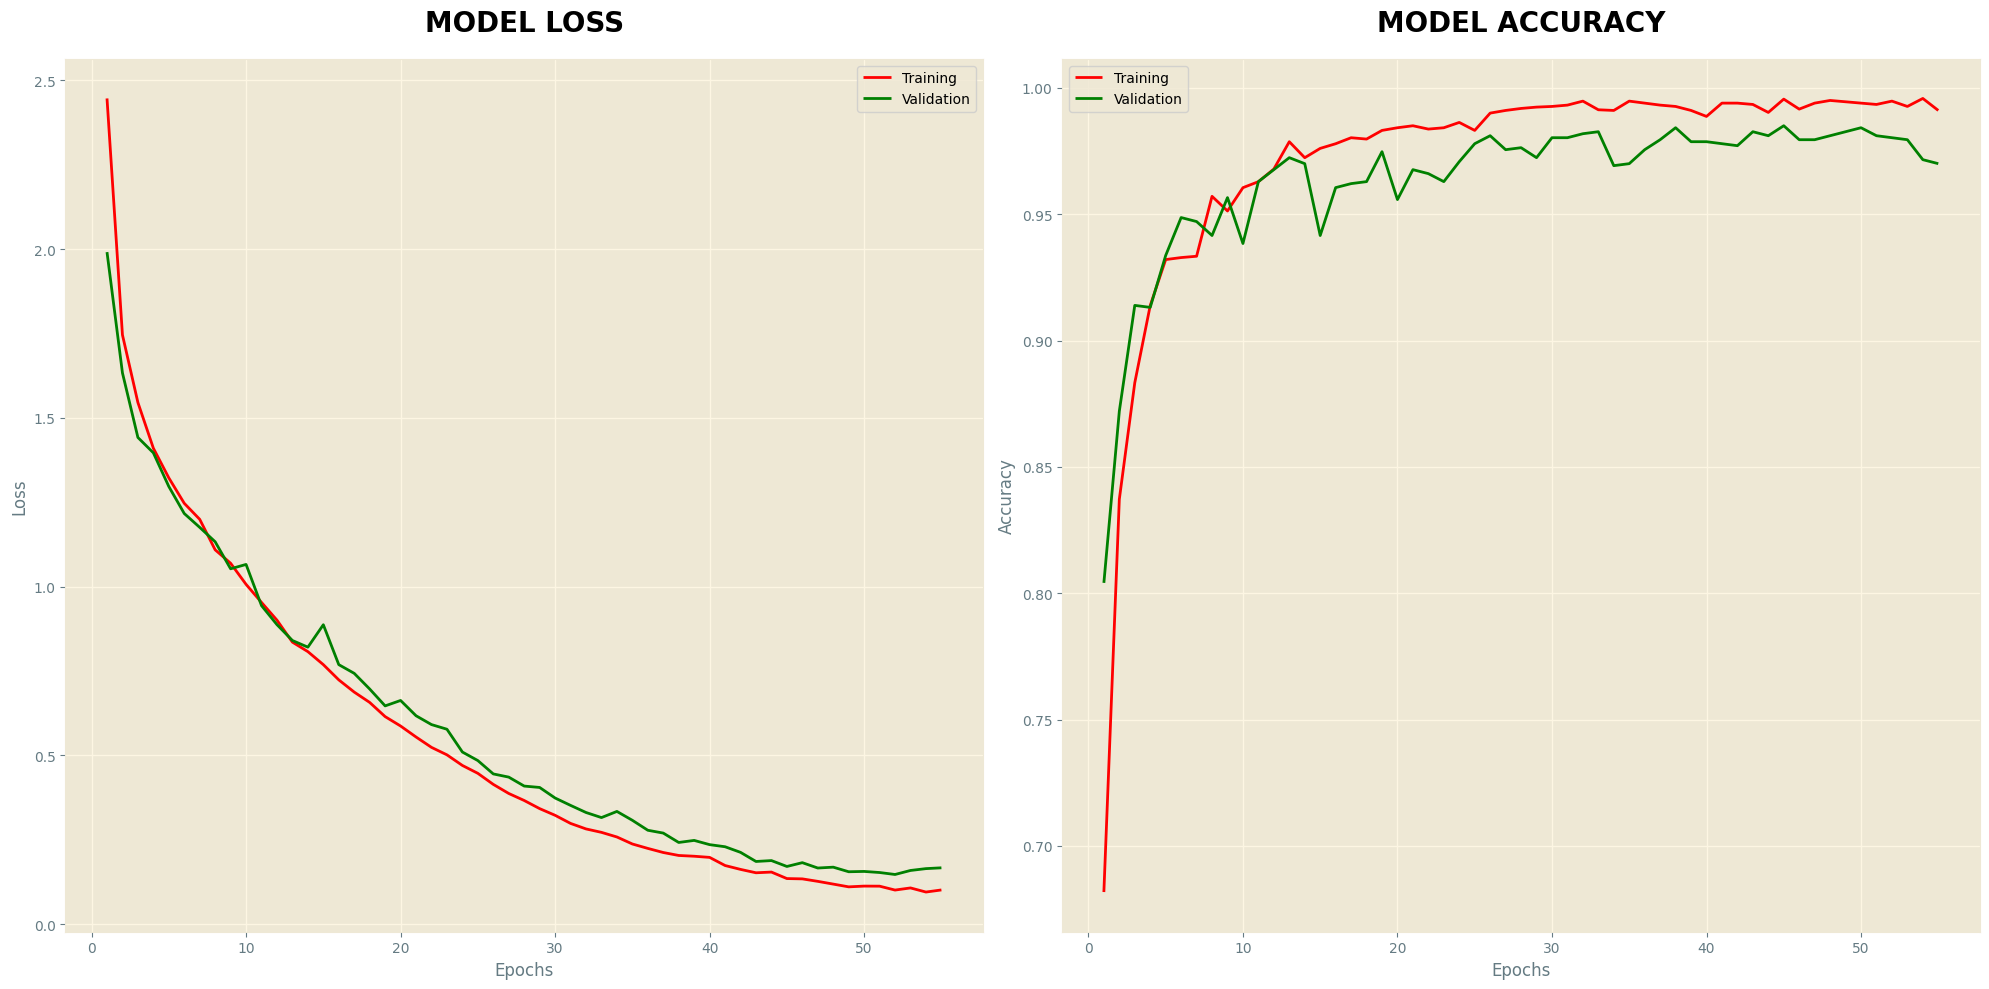

In [15]:
# Extracting accuracy and loss from the training history
train_acc, train_loss = history.history['accuracy'], history.history['loss']
val_acc, val_loss = history.history['val_accuracy'], history.history['val_loss']


# Generating a sequence of epoch numbers
epochs = range(1, len(train_acc) + 1)

# Plotting training and validation loss
plt.figure(figsize=(20, 10))
plt.style.use('Solarize_Light2')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'g', label='Validation')
plt.title('MODEL LOSS', fontsize= 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'g', label='Validation')
plt.title('MODEL ACCURACY', fontsize= 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
train_score = loaded_model.evaluate(train_dataset , steps =10 , verbose = 1)
valid_score = loaded_model.evaluate(valid_dataset , steps = 10 , verbose = 1)
test_score = loaded_model.evaluate(test_dataset , steps = 10 , verbose = 1)

cnn_eval_dict = {
    'Evaluation': ['Loss', 'Accuracy'],
    'Training': [train_score[0], train_score[1]],
    'Testing': [test_score[0], test_score[1]],
    'Validation': [valid_score[0], valid_score[1]],

}

cnn_eval_df = pd.DataFrame(cnn_eval_dict)

10/10 [==============================] - 5s 543ms/step - loss: 0.1407 - accuracy: 0.9812


In [17]:
cnn_eval_df

,Evaluation,Training,Testing,Validation
0,Loss,0.084985,0.140719,0.167344
1,Accuracy,0.993750,0.981250,0.981250


In [18]:
loaded_model.save('brain_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # Check if the input is a DataFrame
    if isinstance(cf, pd.DataFrame):
        cf = cf.values

    # Add 'Total Predicted' column and 'Total Actual' row to the matrix
    total_predicted = np.sum(cf, axis=0)
    total_actual = np.sum(cf, axis=1)
    
    cf = np.vstack([cf, total_predicted])
    cf = np.hstack([cf, np.append(total_actual, np.sum(total_actual)).reshape(-1, 1)])
    grand_total = cf[-1, -1]

    # Set the last row and column to custom colormap
    c = cf.copy()
    c[:-1, :-1] = 0
    masked_cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

    # Adjust box labels
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / grand_total]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        categories = False
    
    if categories == 'auto':
        x_labels = list(range(cf.shape[1] - 1))  # excluding the 'Total' column
        y_labels = list(range(cf.shape[0] - 1))  # excluding the 'Total' row
    else:
        x_labels = categories.copy()
        y_labels = categories.copy()
        
    x_labels.append("Total Predicted")
    y_labels.append("Total Actual")


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cbar=cbar, xticklabels=x_labels, cmap=masked_cmap, yticklabels=y_labels, linewidths=0.5, linecolor="white")
    
    plt.gca().xaxis.tick_top()

    plt.gca().add_patch(plt.Rectangle((cf.shape[1]-1, 0), 1, cf.shape[0], fill=True, color='lightgrey', edgecolor='white', linewidth=0.5))
    plt.gca().add_patch(plt.Rectangle((0, cf.shape[0]-1), cf.shape[1], 1, fill=True, color='lightgrey', edgecolor='white', linewidth=0.5))
    plt.gca().add_patch(plt.Rectangle((2, cf.shape[1]-1), cf.shape[1], 1, fill=True, color='grey', edgecolor='white', linewidth=0.5))

    for i in range(cf.shape[1]):
        plt.gca().add_patch(plt.Rectangle((i, cf.shape[0]-1), 1, 1, fill=False, edgecolor='white', linewidth=0.5))
        plt.gca().add_patch(plt.Rectangle((cf.shape[1]-1, i), 1, 1, fill=False, edgecolor='white', linewidth=0.5))

    if title:
        plt.title(title)
    
    plt.show()


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

predicted_probabilities = loaded_model.predict(test_dataset)

40/40 [==============================] - 20s 428ms/step


In [21]:
predicted_labels = predicted_probabilities.argmax(axis=1)
true_labels = test_dataset.classes

In [22]:
cm = confusion_matrix(true_labels, predicted_labels)

/tmp/ipykernel_27/645610221.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((cf.shape[1]-1, 0), 1, cf.shape[0], fill=True, color='lightgrey', edgecolor='white', linewidth=0.5))
/tmp/ipykernel_27/645610221.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((0, cf.shape[0]-1), cf.shape[1], 1, fill=True, color='lightgrey', edgecolor='white', linewidth=0.5))
/tmp/ipykernel_27/645610221.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((2, cf.shape[1]-1), cf.shape[1], 1, fill=True, color='grey', edgecolor='white', linewidth=0.5))


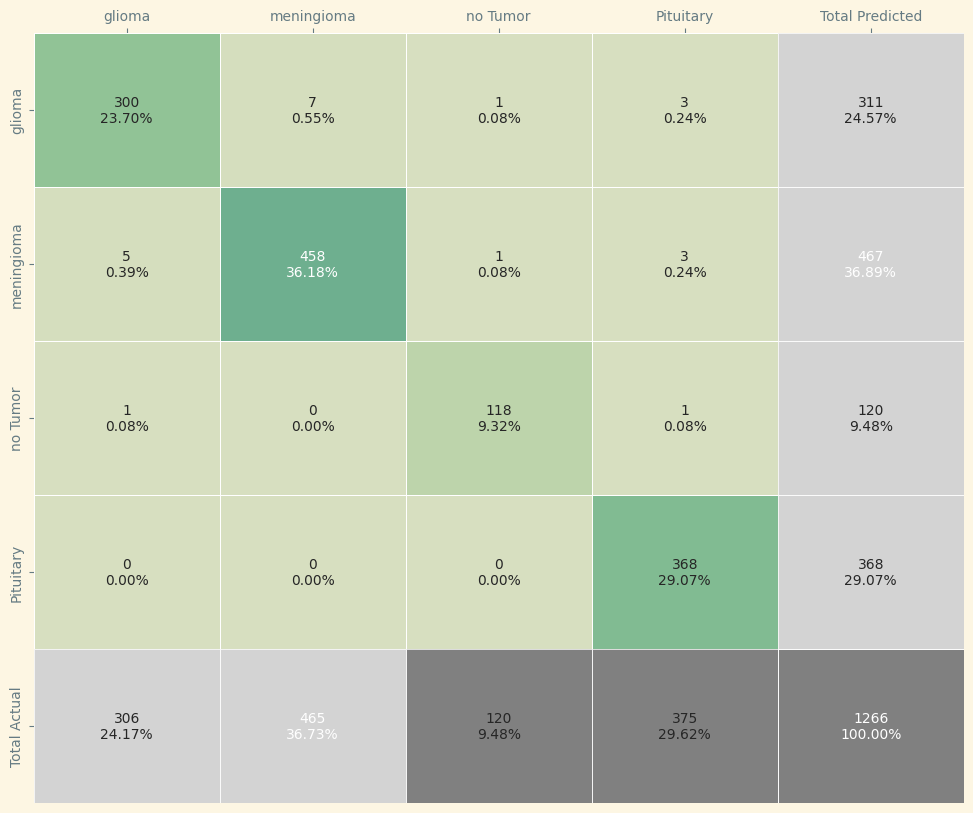

In [23]:
make_confusion_matrix(cm, 
                      categories= ['glioma', 'meningioma', 'no Tumor', 'Pituitary'],
                      figsize = (12,10),
                      cbar = False
                          )

In [24]:
class_report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       311
           1       0.98      0.98      0.98       467
           2       0.98      0.98      0.98       120
           3       0.98      1.00      0.99       368

    accuracy                           0.98      1266
   macro avg       0.98      0.98      0.98      1266
weighted avg       0.98      0.98      0.98      1266

